In [13]:
# import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm

In [14]:
# read og data from drive
df = pd.read_csv('pfas_clean.csv')
df['date'] = pd.to_datetime(df['date'])

In [15]:
# filter data to points and value for testing purposes
df_clean = df[['date', 'PFAS_total', 'longitude', 'latitude']]

In [16]:
# get basin data
file_path = 'stanford-sr396hp9621-shapefile.zip'

# Read the zip file
basins = gpd.read_file('zip://' + file_path)

In [17]:
# Assuming your regular pandas DataFrame is df_points
geometry = [Point(xy) for xy in zip(df_clean['longitude'], df_clean['latitude'])]
df_points = gpd.GeoDataFrame(df_clean, geometry=geometry)
# drop long lat, no longer needed
df_points = df_points.drop(['longitude', 'latitude'], axis = 1)

In [18]:
# does groupby by taking the first value
df_points_unique_first = df_points.groupby('geometry').first().reset_index()
df_points_unique_first = df_points_unique_first.dropna(subset=['geometry'])

In [19]:
# does groupby by avg
df_points_unique_mean= df_points.groupby('geometry').mean(numeric_only=True).reset_index()
df_points_unique_mean = df_points_unique_mean.dropna(subset=['geometry'])

In [20]:
# groupby get latest date
latest_date_indices = df_points.groupby('geometry')['date'].idxmax()
df_points_unique_latest_date = df_points.loc[latest_date_indices].reset_index(drop=True)

In [21]:
# we will use latest date, can change later
# joining basins with points
df_points_unique_latest_date.crs = 'EPSG:4326'
basins = basins.to_crs(df_points_unique_latest_date.crs)
result = gpd.sjoin(df_points_unique_latest_date, basins, how='right', predicate='within') #change predicate?

In [22]:
# save and use as data
without_load_date = result.drop(['date','loaddate'], axis=1, inplace=False)

without_load_date.to_file('basin_join_pfas/basin_join_pfas.shp')

In [23]:
# get CA bounding box
# find how long/lat correlates to area
map_boundary = result.total_bounds
print("Map Boundary:", map_boundary)
# negative is long, positive lat

Map Boundary: [-124.53512391   31.64409828 -113.05084271   43.00797516]


In [26]:
result.head(5)

,date,PFAS_total,tnmid,metasource,sourcedata,sourceorig,sourcefeat,loaddate,gnis_id,areaacres,areasqkm,states,huc8,name,shape_star,shape_stle,geometry
0,2022-03-29,989.7,{1D790622-4BC5-4E35-9C0C-0F0192C2D49F},None,None,None,None,2012-06-11,0.0,645676.0,2613.016031,CA,18020156,Thomes Creek-Sacramento River,0.275898,4.450838,"POLYGON ((-121.50734 40.48375, -121.50730 40.4..."
1,2020-12-03,66.8,{5AE4114D-8323-42BB-9F33-8B7C27B16203},None,None,None,None,2012-06-11,0.0,1198581.0,4850.592025,CA,18040009,Upper Tuolumne,0.496950,6.338565,"POLYGON ((-119.65612 38.22947, -119.65575 38.2..."
1,2021-01-13,65.5,{5AE4114D-8323-42BB-9F33-8B7C27B16203},None,None,None,None,2012-06-11,0.0,1198581.0,4850.592025,CA,18040009,Upper Tuolumne,0.496950,6.338565,"POLYGON ((-119.65612 38.22947, -119.65575 38.2..."
1,2021-03-09,62.8,{5AE4114D-8323-42BB-9F33-8B7C27B16203},None,None,None,None,2012-06-11,0.0,1198581.0,4850.592025,CA,18040009,Upper Tuolumne,0.496950,6.338565,"POLYGON ((-119.65612 38.22947, -119.65575 38.2..."
1,2021-03-09,65.5,{5AE4114D-8323-42BB-9F33-8B7C27B16203},None,None,None,None,2012-06-11,0.0,1198581.0,4850.592025,CA,18040009,Upper Tuolumne,0.496950,6.338565,"POLYGON ((-119.65612 38.22947, -119.65575 38.2..."


In [ ]:
# Define grid cell size in kilometers
granularity = .01 # Adjust as needed

# Create a bounding box around area
xmin, ymin, xmax, ymax = result.total_bounds
x_grid = np.arange(xmin, xmax, granularity)
y_grid = np.arange(ymin, ymax, granularity)

# Create a GeoDataFrame for the grid
grid_cells = gpd.GeoDataFrame(geometry=[Polygon([(x, y), (x + granularity, y), (x + granularity, y + granularity), (x, y + granularity)]) for x in x_grid for y in y_grid], crs="EPSG:4326")

In [28]:
# Define grid cell size in kilometers
granularity = .01 # Adjust as needed

# Create a bounding box around area
xmin, ymin, xmax, ymax = result.total_bounds
x_grid = np.arange(xmin, xmax, granularity)
y_grid = np.arange(ymin, ymax, granularity)

grid = []

for x in x_grid:
    for y in y_grid:
        temp = np.empty((7,7), dtype=object) # this can changed
        for i in range(-3, 4):
            for j in range(-3, 4):
                curr_x, curr_y = x + i * granularity, y + j * granularity

                if xmin <= curr_x <= xmax and ymin <= curr_y <= ymax: # bounds check
                    individual_point = Point(curr_x, curr_y)
                    pfas_val = 0
                    for _, basin in result.iterrows(): # search through basins
                        if individual_point.intersects(basin['geometry']):
                            pfas_val = basin['PFAS_total'] 
                            break # stop at first one
                    
                    temp[i + 3, j + 3] = {'geometry': individual_point, 'longitude': x, 'latitude': y, 'PFAS_total': pfas_val}
        
        grid.append(temp)

grid_array = np.array(grid)

KeyboardInterrupt: 

In [24]:
result = result.drop('index_left', axis=1) # maybe rename left_index to something else

In [25]:
# Spatial join using sjoin with predicate parameter
joined = gpd.sjoin(grid_cells, result, how="left", op='intersects') # change op to predicate

joined.head()

NameError: name 'grid_cells' is not defined

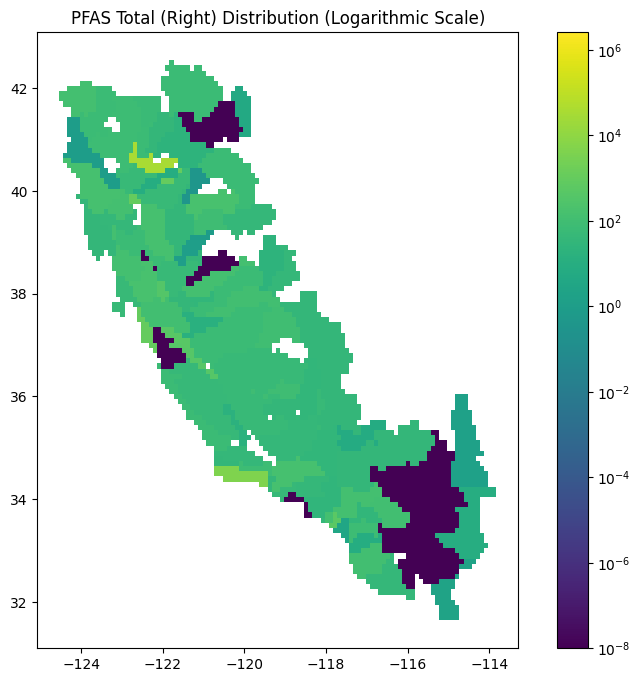

In [49]:
offset = 1e-8
joined['log_PFAStotal'] = joined['PFAS_total_right'] + offset
vmin = joined['log_PFAStotal'].min()  # Set to the minimum non-zero value
vmax = joined['log_PFAStotal'].max()
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
joined.plot(column='log_PFAStotal', cmap='viridis', legend=True, norm=LogNorm(vmin=vmin, vmax=vmax), ax=ax)

# Add a title and show the plot
plt.title('PFAS Total (Right) Distribution (Logarithmic Scale)')
plt.savefig('PFAS_total_log_plot', dpi=450)
plt.show()

In [40]:
filtered_rows = joined[joined['PFAS_total_right'].notna()]
filtered_rows['PFAS_total_right'].describe()

count    2.426160e+05
mean     1.514427e+03
std      3.364363e+04
min      0.000000e+00
25%      3.240000e+01
50%      4.930000e+01
75%      7.850000e+01
max      2.590829e+06
Name: PFAS_total_right, dtype: float64

In [16]:
for idx, cell in grid_cells.iterrows():
  for result_idx, result_row in result.iterrows():
    if cell.geometry.intersects(result_row.geometry):
      grid_cells.at[idx, 'PFAS_total'] = result_row['PFAS_total']
      continue
# grid_cells.to_file('grid_with_pfas.zip', driver='ESRI Shapefile') # useless
# Define the colormap for PFAS values
cmap = plt.get_cmap('viridis')

# Normalize the PFAS values to fit the colormap
norm = Normalize(vmin=grid_cells['PFAS_total'].min(), vmax=grid_cells['PFAS_total'].max())

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the grid cells with PFAS coloring
grid_cells.plot(column='PFAS_total', cmap=cmap, norm=norm, ax=ax, legend=True)

# Add a title
ax.set_title("Grid Cells with PFAS Coloring")

# Show the plot
plt.show()

KeyboardInterrupt: 

In [17]:
grid_cells['PFAS_total'].fillna(0, inplace=True)
grid_cells['PFAS_total'].isna().sum()


/tmp/ipykernel_1126/2702717634.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  grid_cells['PFAS_total'].fillna(0, inplace=True)


0



```
go through every basin:
  find all points within that basin location by coordinate
  avg/take last known point, assign to new col in basin = PFAS total for ex.
  if na: leave NA

----- GRID

define GRID itself which we can change 1sqkm etc. == i think already done

go through all squares in grid:
  take middle of square and find which basin it lies on
  assign PFAS_total & Basin(? what this mean == have to do for all map data) = for categorical give num? for numerical give num OR binary ex. river = T/F
```

